# Problem Statement
Our client, a leading insurance company, is seeking your expertise in developing a predictive model to identify potential customers interested in purchasing Vehicle Insurance. Having successfully provided Health Insurance to a substantial customer base, the company aims to strategically expand its offerings to include Vehicle Insurance.

The task is to build a robust machine learning model that can analyze customer data from the previous year and predict the likelihood of those policyholders showing interest in acquiring Vehicle Insurance from the company. The primary goal is to optimize the cross-selling strategy, enabling the insurance provider to target the right audience and enhance its overall business model.

# Background
An insurance policy serves as a guarantee, providing compensation for specified losses, damages, illnesses, or death in return for regular premium payments. Vehicle Insurance, a significant segment of insurance products, requires customers to pay premiums regularly in exchange for coverage against unfortunate incidents involving their vehicles.

# Objective
Develop a predictive model to discern whether policyholders from the previous year are inclined to purchase Vehicle Insurance. This model should leverage demographic information (gender, age, region code type), details about the vehicles (Vehicle Age, Damage), and policy-related data (Premium, sourcing channel).

# Importance
* **Optimized Communication Strategy:** The predictive model will guide the company in tailoring its communication strategy. By identifying customers likely to be interested in Vehicle Insurance, the insurer can create targeted and personalized outreach, maximizing the effectiveness of marketing efforts.
* **Revenue Optimization:** Understanding customer preferences enables the insurance company to optimize its business model. By strategically expanding its offerings based on customer needs, the company can potentially increase revenue and enhance its overall market position.

# Modeling Approach
* Data was split into training and validation sets.
* Base models (Random Forest, XGBoost, Multi-Layer Perceptron (MLP) classifier) were trained on the training data.
* Predictions were made on the validation set using the base models.
* A meta-model (LightGBM) was built using predictions from the base models on the validation set.
* The meta-model was used to predict outcomes on the test set.
* Individual base models' accuracy was evaluated on the validation set.
* The accuracy of the stacked model was assessed on the validation set.
* ROC curve and AUC were calculated to evaluate the stacked model's performance.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from prettytable import PrettyTable
import os
import warnings
warnings.simplefilter("ignore")

In [6]:
for dirname, _, filenames in os.walk('/kaggle/input/health-insurance-cross-sell-prediction'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [7]:
# Load the training and test datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [8]:
# Display information about the DataFrame, including data types and non-null counts
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [9]:
# Display basic statistics of the numerical columns
print("\nTraining Dataset Statistics:")
print(train.describe())


Training Dataset Statistics:
                  id            Age  Driving_License    Region_Code  \
count  381109.000000  381109.000000    381109.000000  381109.000000   
mean   190555.000000      38.822584         0.997869      26.388807   
std    110016.836208      15.511611         0.046110      13.229888   
min         1.000000      20.000000         0.000000       0.000000   
25%     95278.000000      25.000000         1.000000      15.000000   
50%    190555.000000      36.000000         1.000000      28.000000   
75%    285832.000000      49.000000         1.000000      35.000000   
max    381109.000000      85.000000         1.000000      52.000000   

       Previously_Insured  Annual_Premium  Policy_Sales_Channel  \
count       381109.000000   381109.000000         381109.000000   
mean             0.458210    30564.389581            112.034295   
std              0.498251    17213.155057             54.203995   
min              0.000000     2630.000000              1.00000

# Dataset Features Overview
* id: Unique identifier for each record.
* Gender: The gender of the customer.
* Age: The age of the customer.
* Driving_License: Indicates whether the customer has a driving license (binary: 0 for No, 1 for Yes).
* Region_Code: Code representing the region of the customer.
* Previously_Insured: Indicates whether the customer had vehicle insurance in the past (binary: 0 for No, 1 for Yes).
* Vehicle_Age: The age of the customer's vehicle.
* Vehicle_Damage: Indicates whether the customer's vehicle has been damaged in the past (binary: 0 for No, 1 for Yes).
* Annual_Premium: The amount the customer needs to pay as a premium for insurance.
* Policy_Sales_Channel: Code representing the channel through which the policy was sold.
* Vintage: Number of days the customer has been associated with the company.
* Response: The target variable indicating whether the customer is interested in Vehicle Insurance (binary: 0 for No, 1 for Yes).

In [10]:
# Display the shape of the datasets
print(train.shape)
print(test.shape)

(381109, 12)
(127037, 11)


In [11]:
# Display the first few rows of the training dataset
print("\nFirst Few Rows of Training Dataset:")
print(train.head())


First Few Rows of Training Dataset:
   id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0   1    Male   44                1         28.0                   0   
1   2    Male   76                1          3.0                   0   
2   3    Male   47                1         28.0                   0   
3   4    Male   21                1         11.0                   1   
4   5  Female   29                1         41.0                   1   

  Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  \
0   > 2 Years            Yes         40454.0                  26.0      217   
1    1-2 Year             No         33536.0                  26.0      183   
2   > 2 Years            Yes         38294.0                  26.0       27   
3    < 1 Year             No         28619.0                 152.0      203   
4    < 1 Year             No         27496.0                 152.0       39   

   Response  
0         1  
1         0  
2         1  

In [12]:
# Check for missing values in the training dataset
print("\nMissing Values in Training Dataset:")
print(train.isnull().sum())


Missing Values in Training Dataset:
id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64


# Data Exploration and Visualization
* **Gender and age distribution**

<Figure size 1200x800 with 0 Axes>

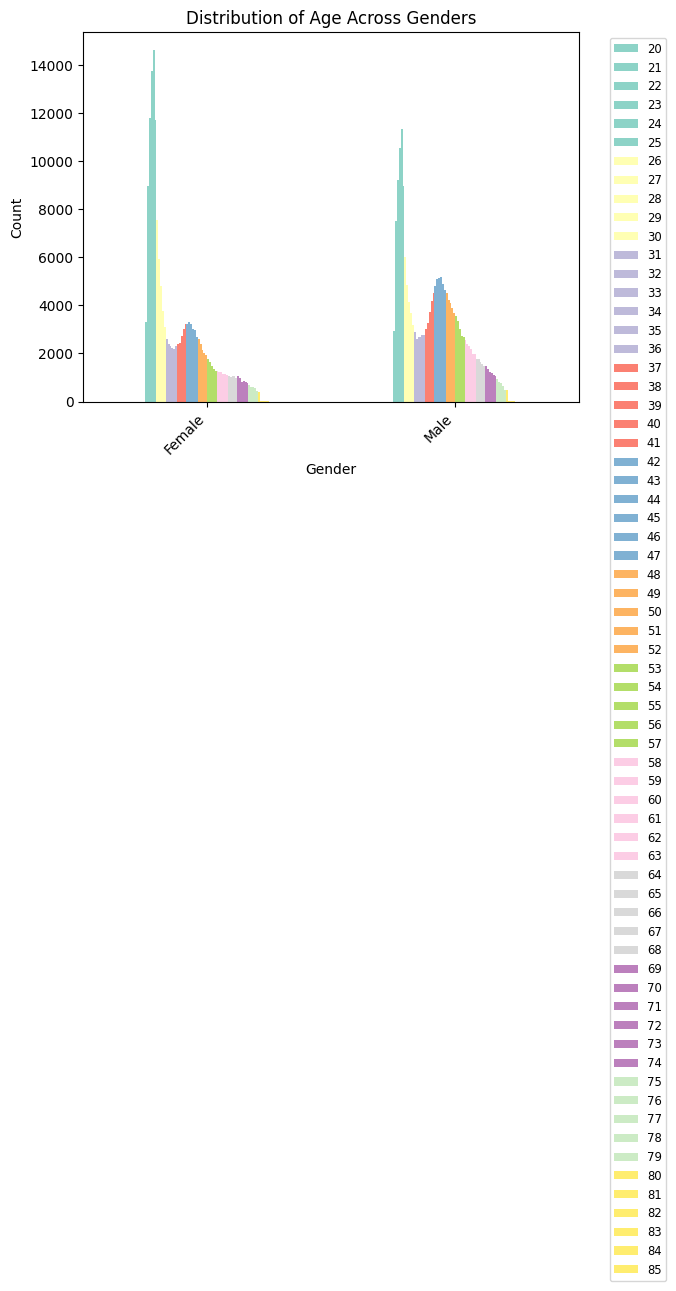

In [13]:
gender_age_counts = train.groupby(['Gender', 'Age']).size().unstack()

# Plotting a grouped bar chart
plt.figure(figsize=(12, 8))
ax = gender_age_counts.plot(kind='bar', stacked=False, cmap='Set3')
plt.title('Distribution of Age Across Genders')
plt.xlabel('Gender')
plt.ylabel('Count')

# Rotate x-axis labels by 45 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Adjust legend size and position
plt.legend(fontsize='small', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

* **Distribution of vehicle age**

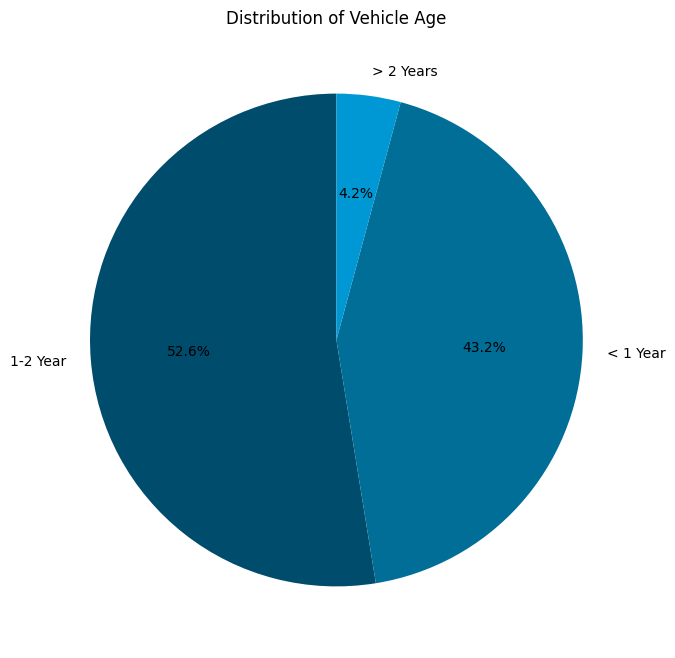

In [14]:
vehicle_age_counts = train['Vehicle_Age'].value_counts()

# Darker colors
colors = ['#004c6d', '#006e96', '#0098d4']

plt.figure(figsize=(8, 8))
plt.pie(vehicle_age_counts, labels=vehicle_age_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Distribution of Vehicle Age')
plt.show()

* **Distribution of vehicle damage**

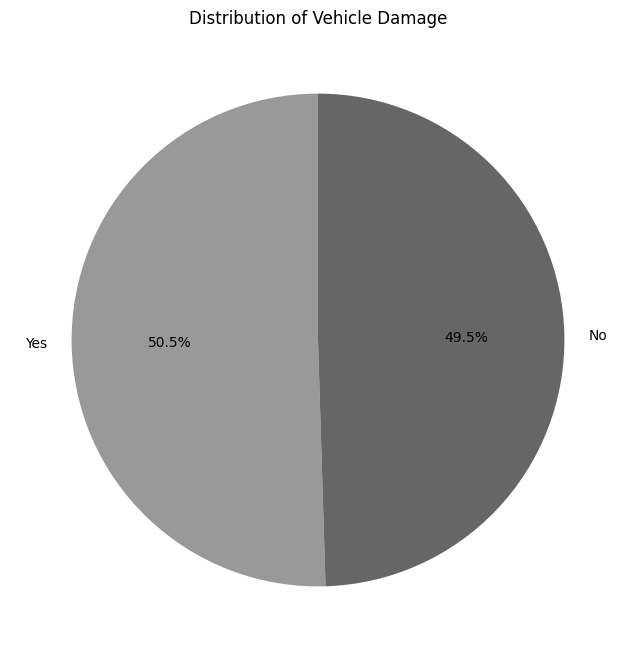

In [15]:
# Calculate the counts of vehicle damage
vehicle_damage_counts = train['Vehicle_Damage'].value_counts()

# Define shades of grey
colors_grey = ['#999999', '#666666']

# Plotting a pie chart with grey colors
plt.figure(figsize=(8, 8))
plt.pie(vehicle_damage_counts, labels=vehicle_damage_counts.index, autopct='%1.1f%%', startangle=90, colors=colors_grey)
plt.title('Distribution of Vehicle Damage')
plt.show()

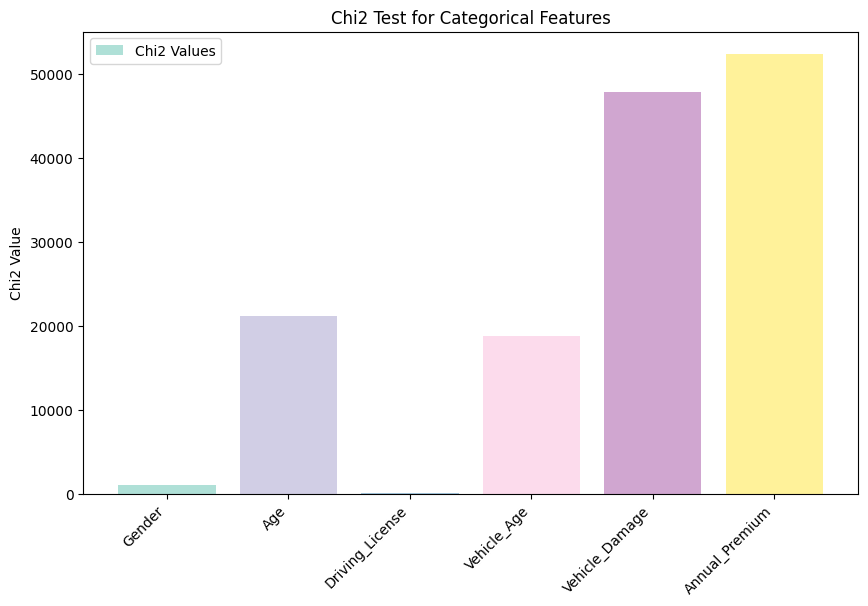

In [16]:
categorical_features = ['Gender', 'Age', 'Driving_License', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium']

# Lists to store results
chi2_values = []
p_values = []

# Loop through each categorical feature
for feature in categorical_features:
    # Create a contingency table
    contingency_table = pd.crosstab(train[feature], train['Response'])
    
    # Perform chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Append results to lists
    chi2_values.append(chi2)
    p_values.append(p)

# Plotting with different dark colors for each bar
fig, ax = plt.subplots(figsize=(10, 6))
x_pos = np.arange(len(categorical_features))
colors = plt.cm.Set3(np.linspace(0, 1, len(categorical_features)))

# Plot chi2 values with different dark colors for each bar
ax.bar(x_pos, chi2_values, align='center', alpha=0.7, color=colors, label='Chi2 Values')
ax.set_xticks(x_pos)
ax.set_xticklabels(categorical_features, rotation=45, ha='right')
ax.set_ylabel('Chi2 Value')
ax.set_title('Chi2 Test for Categorical Features')
ax.legend()

# Show the plot
plt.show()

# Feature Engineering

In [17]:
# Feature Engineering
gender_mapping = {'Male': 1, 'Female': 0}
vehicle_age_mapping = {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}
vehicle_damage_mapping = {'Yes': 1, 'No': 0}

train['Gender'] = train['Gender'].map(gender_mapping).astype('int')
train['Vehicle_Age'] = train['Vehicle_Age'].map(vehicle_age_mapping).astype('int')
train['Vehicle_Damage'] = train['Vehicle_Damage'].map(vehicle_damage_mapping).astype('int')

test['Gender'] = test['Gender'].map(gender_mapping).astype('int')
test['Vehicle_Age'] = test['Vehicle_Age'].map(vehicle_age_mapping).astype('int')
test['Vehicle_Damage'] = test['Vehicle_Damage'].map(vehicle_damage_mapping).astype('int')

# Separate features and target variable in the training set
X_train = train.drop('Response', axis=1)
y_train = train['Response']

# Correlation Analysis

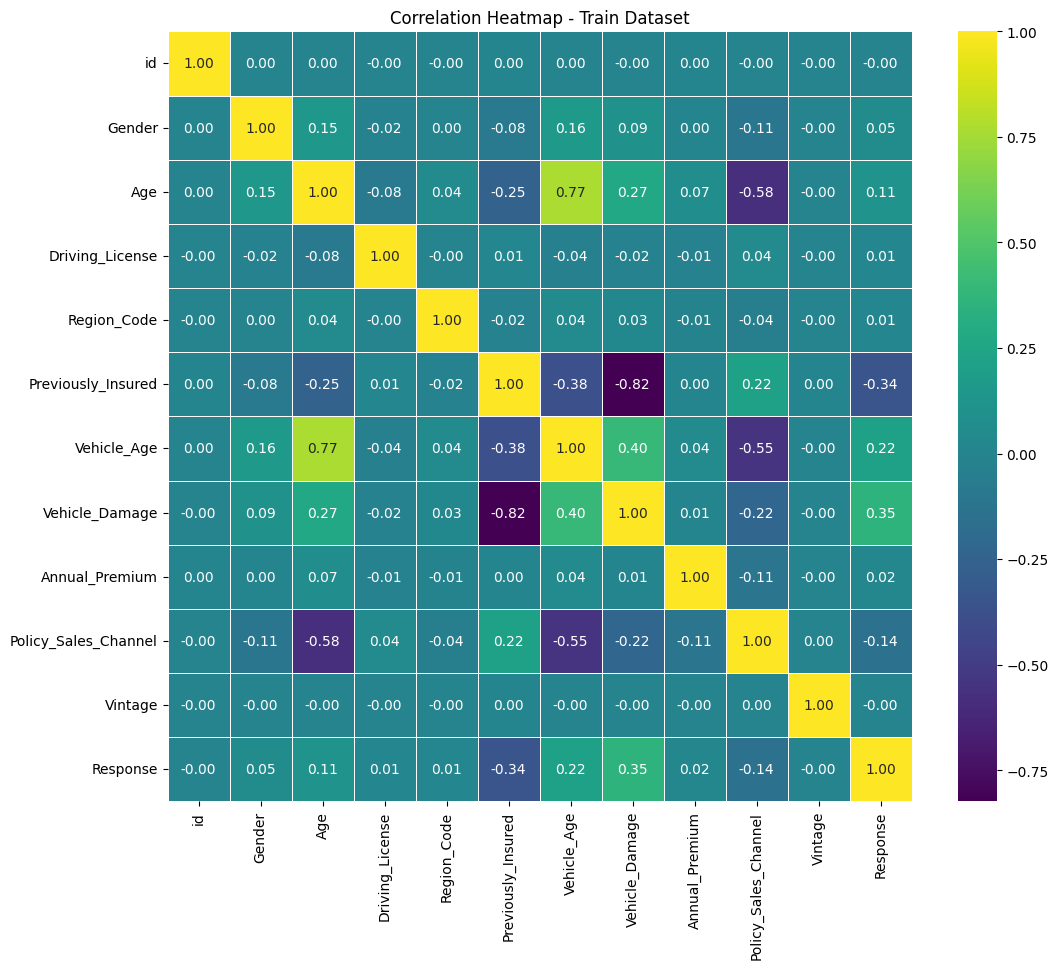

In [18]:
# Calculate the correlation matrix
corr_matrix = train.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap with seaborn using the "viridis" colormap
sns.heatmap(corr_matrix, annot=True, cmap="viridis", fmt=".2f", linewidths=.5)

# Set the title of the plot
plt.title('Correlation Heatmap - Train Dataset')

# Display the plot
plt.show()

# Data Splitting

In [19]:
# Split the data into training and testing sets
X_train_base, X_val, y_train_base, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Fitting Base Models (Random Forest, XGBoost, MLP classifier)

In [20]:
# Base Models
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)
nn_model = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=1000, random_state=42)

# Fit the base models
rf_model.fit(X_train_base, y_train_base)
xgb_model.fit(X_train_base, y_train_base)
nn_model.fit(X_train_base, y_train_base)

MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=1000, random_state=42)

# Predictions and Accuracy for Base Models

In [21]:
# Predictions from base models on the validation set
rf_predictions_val = rf_model.predict_proba(X_val)[:, 1]
xgb_predictions_val = xgb_model.predict_proba(X_val)[:, 1]
nn_predictions_val = nn_model.predict_proba(X_val)[:, 1]

# Set the threshold for binary classification
threshold = 0.58

# Calculate accuracy for each base model on the validation set
rf_accuracy_val = accuracy_score(y_val, (rf_predictions_val >= threshold).astype(int))
xgb_accuracy_val = accuracy_score(y_val, (xgb_predictions_val >= threshold).astype(int))
nn_accuracy_val = accuracy_score(y_val, (nn_predictions_val >= threshold).astype(int))

# Display the accuracy for each base model on the validation set
print("Validation Set:")
print(f"Random Forest Model Accuracy: {rf_accuracy_val:.4f}")
print(f"XGBoost Model Accuracy: {xgb_accuracy_val:.4f}")
print(f"Neural Network Model Accuracy: {nn_accuracy_val:.4f}")

Validation Set:
Random Forest Model Accuracy: 0.8735
XGBoost Model Accuracy: 0.8749
Neural Network Model Accuracy: 0.8751


In [22]:
# Create a DataFrame with base model predictions for the validation set
base_model_predictions_val = pd.DataFrame({
    'RandomForest': rf_predictions_val,
    'XGBoost': xgb_predictions_val,
    'Multi-layer Perceptron': nn_predictions_val
})

# Meta-Model (Stacking)

In [23]:
# Meta Model
meta_model = LGBMClassifier(random_state=42)

# Fit the meta model on base model predictions
meta_model.fit(base_model_predictions_val, y_val)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 9523, number of negative: 66699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 335
[LightGBM] [Info] Number of data points in the train set: 76222, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124938 -> initscore=-1.946480
[LightGBM] [Info] Start training from score -1.946480


LGBMClassifier(random_state=42)

# Predictions on Test Set Using Base Models

In [24]:
# Predictions from base models on the test set
rf_predictions_test = rf_model.predict_proba(test)[:, 1]
xgb_predictions_test = xgb_model.predict_proba(test)[:, 1]
nn_predictions_test = nn_model.predict_proba(test)[:, 1]


# Predictions on Validation Set Using the Meta-Model (Stacking)

In [25]:
# Make predictions on the validation set using the meta-model
meta_model_predictions_val = meta_model.predict_proba(base_model_predictions_val)[:, 1]

# Apply threshold to get binary predictions for the stacked model
binary_stacked_predictions_val = (meta_model_predictions_val >= threshold).astype(int)

# Calculate accuracy for the stacked model on the validation set
stacked_accuracy_val = accuracy_score(y_val, binary_stacked_predictions_val)
print(f'Stacked Model Accuracy on Validation Set: {stacked_accuracy_val:.4f}')

Stacked Model Accuracy on Validation Set: 0.8755


# Blending Predictions on the Validation Set

In [26]:
# Blend predictions
blended_predictions_val = 0.7 * xgb_predictions_val + 0.2 * rf_predictions_val + 0.1 * nn_predictions_val

# Apply threshold to get binary predictions for the blended model
binary_blended_predictions_val = (blended_predictions_val >= threshold).astype(int)

# Calculate accuracy for the blended model on the validation set
blended_accuracy_val = accuracy_score(y_val, binary_blended_predictions_val)
print(f'Blended Model Accuracy on Validation Set: {blended_accuracy_val:.4f}')

Blended Model Accuracy on Validation Set: 0.8751


# Model Percentages for Stacking

In [27]:
# Make predictions on the test set using the meta-model
meta_model_predictions_test = meta_model.predict_proba(np.column_stack((rf_predictions_test, xgb_predictions_test, nn_predictions_test)))[:, 1]

# Calculate individual model percentages
rf_percentage = (rf_predictions_test / meta_model_predictions_test).mean() * 100
xgb_percentage = (xgb_predictions_test / meta_model_predictions_test).mean() * 100
nn_percentage = (nn_predictions_test / meta_model_predictions_test).mean() * 100

# Normalize percentages to sum to 100%
total_percentage = rf_percentage + xgb_percentage + nn_percentage
rf_percentage_normalized = (rf_percentage / total_percentage) * 100
xgb_percentage_normalized = (xgb_percentage / total_percentage) * 100
nn_percentage_normalized = (nn_percentage / total_percentage) * 100

# Display the normalized percentages
print(f"Random Forest Model Percentage: {rf_percentage_normalized:.2f}%")
print(f"XGBoost Model Percentage: {xgb_percentage_normalized:.2f}%")
print(f"Neural Network Model Percentage: {nn_percentage_normalized:.2f}%")

Random Forest Model Percentage: 3.19%
XGBoost Model Percentage: 0.65%
Neural Network Model Percentage: 96.16%


# Setting Threshold and Making Predictions on the Test Set Using the Meta-Model

In [28]:
# Set the threshold for binary classification
threshold = 0.58

# Apply the threshold to get binary predictions
binary_predictions = (meta_model_predictions_test >= threshold).astype(int)

# Creating a DataFrame with Final Binary Predictions and Saving to CSV

In [31]:
# Create a DataFrame with the 'id' column from the test dataset and binary 'Response'
output_df = pd.DataFrame({'id': test['id'], 'Response': binary_predictions})

# Save the final binary predictions to a CSV file
output_df.to_csv('predictions.csv', index=False)

# ROC Curve and AUC

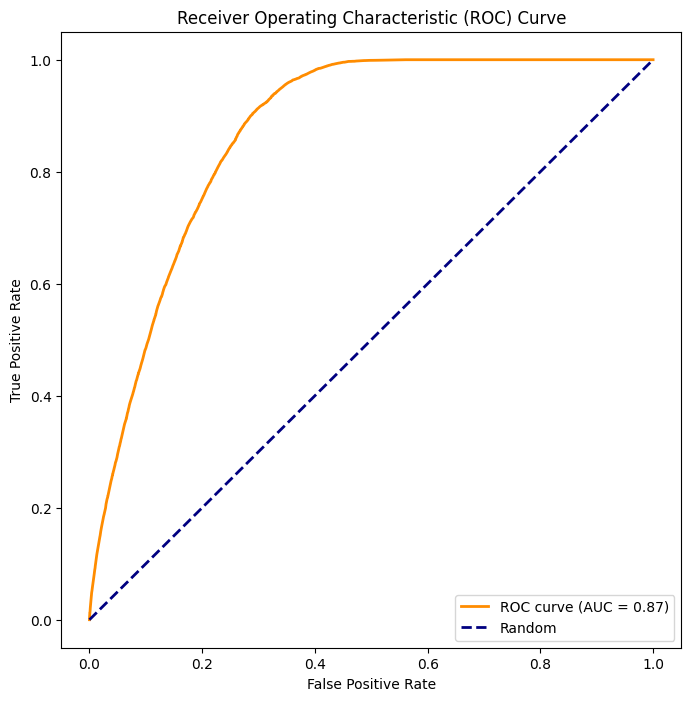

In [32]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_val, meta_model_predictions_val)

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix and Metrics

In [33]:
# Assuming binary_predictions is a NumPy array
binary_predictions = binary_predictions[:len(y_val)]

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val, binary_predictions)
print(conf_matrix)

[[66622    77]
 [ 9514     9]]


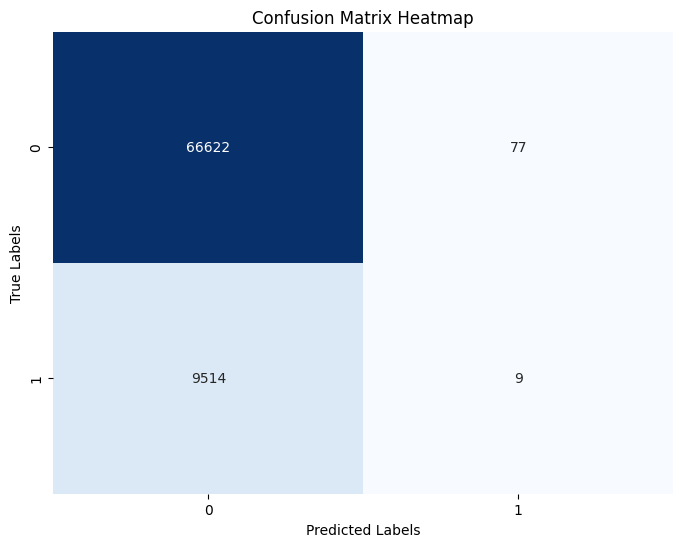

In [34]:
# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [35]:
# Extract values
tn, fp, fn, tp = conf_matrix[0][0], conf_matrix[0][1], conf_matrix[1][0], conf_matrix[1][1]

# Calculate metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Create a PrettyTable instance
table = PrettyTable()

# Define table columns
table.field_names = ["Metric", "Value"]

# Add rows with metrics
table.add_row(["Accuracy", f"{accuracy:.4f}"])
table.add_row(["Precision", f"{precision:.4f}"])
table.add_row(["Recall", f"{recall:.4f}"])
table.add_row(["F1 Score", f"{f1:.4f}"])

# Print the table
print(table)

+-----------+--------+
|   Metric  | Value  |
+-----------+--------+
|  Accuracy | 0.8742 |
| Precision | 0.1047 |
|   Recall  | 0.0009 |
|  F1 Score | 0.0019 |
+-----------+--------+
